In [ ]:
# 1. Clone repositori dari GitHub
!git clone https://github.com/muhammad-irgi/model_capstone.git

Cloning into 'model_capstone'...
remote: Enumerating objects: 25490, done.
remote: Total 25490 (delta 0), reused 0 (delta 0), pack-reused 25490 (from 1)
Receiving objects: 100% (25490/25490), 2.41 GiB | 17.51 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (25468/25468), done.


In [ ]:
import os
import random
import shutil
from pathlib import Path

# 1. Tentukan path ke dataset yang di-clone dari GitHub
data_dir = '/content/model_capstone/potato_data'  # Ganti dengan path sesuai lokasi dataset Anda
output_dir = '/content/split_data'  # Folder baru untuk data terorganisir (train, val, test)

# 2. Buat folder baru untuk train, val, dan test
for folder in ['train', 'val', 'test']:
    for class_dir in os.listdir(data_dir):
        Path(os.path.join(output_dir, folder, class_dir)).mkdir(parents=True, exist_ok=True)

# 3. Bagi data menjadi train, val, dan test
split_ratio = {'train': 0.6, 'val': 0.2, 'test': 0.2}  # 60% train, 20% val, 20% test

for class_dir in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_dir)
    images = os.listdir(class_path)
    random.shuffle(images)  # Acak urutan file

    train_idx = int(split_ratio['train'] * len(images))
    val_idx = train_idx + int(split_ratio['val'] * len(images))

    # Pindahkan file ke folder masing-masing
    for idx, image in enumerate(images):
        src_path = os.path.join(class_path, image)
        if idx < train_idx:
            shutil.copy(src_path, os.path.join(output_dir, 'train', class_dir))
        elif idx < val_idx:
            shutil.copy(src_path, os.path.join(output_dir, 'val', class_dir))
        else:
            shutil.copy(src_path, os.path.join(output_dir, 'test', class_dir))

print("Data telah berhasil dipisahkan ke train, val, dan test!")


Data telah berhasil dipisahkan ke train, val, dan test!


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path ke dataset yang sudah dipisahkan
train_dir = '/content/split_data/train'
val_dir = '/content/split_data/val'
test_dir = '/content/split_data/test'

# 1. ImageDataGenerator untuk memuat data
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# 2. Membuat model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularisasi untuk mencegah overfitting
    Dense(train_generator.num_classes, activation='softmax')  # Output sesuai jumlah kelas
])

# 3. Kompilasi model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 4. Melatih model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Anda bisa menyesuaikan jumlah epoch
)

# 5. Evaluasi model pada data uji
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")


Found 2442 images belonging to 3 classes.
Found 813 images belonging to 3 classes.
Found 817 images belonging to 3 classes.
Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.3930 - loss: 1.1148 - val_accuracy: 0.6248 - val_loss: 0.8806
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6214 - loss: 0.8466 - val_accuracy: 0.7171 - val_loss: 0.7108
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7402 - loss: 0.6729 - val_accuracy: 0.7232 - val_loss: 0.6500
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7640 - loss: 0.5644 - val_accuracy: 0.8253 - val_loss: 0.4752
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8456 - loss: 0.3952 - val_accuracy: 0.8585 - val_loss: 0.4897
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8759 - loss: 0.3424 - val_accuracy: 0.8696 - val_loss: 0.3455
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8989 - loss: 0.2945 - val_accuracy: 0.8856 - va

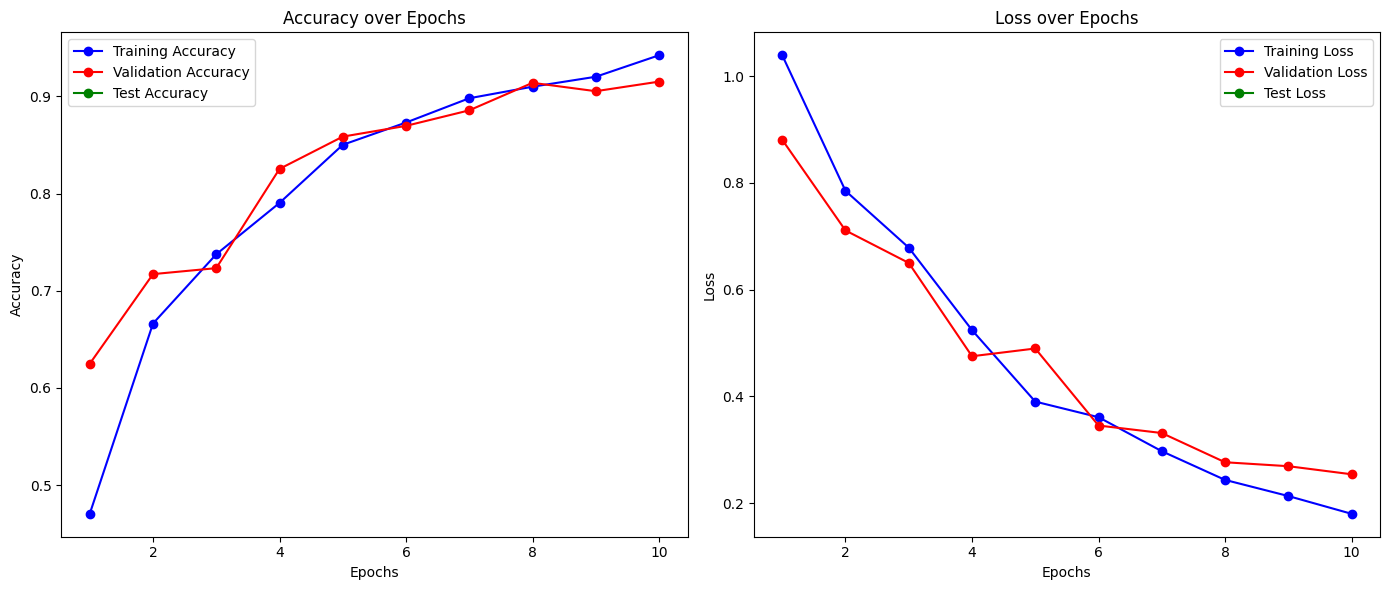

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Callback untuk menghitung metrik test
class TestMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_generator):
        super().__init__()
        self.test_generator = test_generator
        self.test_acc = []
        self.test_loss = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = self.model.evaluate(self.test_generator, verbose=0)
        self.test_acc.append(test_acc)
        self.test_loss.append(test_loss)

# Tambahkan callback saat melatih model
test_callback = TestMetricsCallback(test_generator)

def plot_training_validation_test(history, test_callback):
    # Data pelatihan dan validasi
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Data test dari callback
    test_acc = test_callback.test_acc
    test_loss = test_callback.test_loss

    # Pastikan jumlah epoch sama
    epochs = range(1, len(acc) + 1)
    test_epochs = range(1, len(test_acc) + 1)

    # Plot Akurasi
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.plot(test_epochs, test_acc, 'go-', label='Test Accuracy')  # Sesuaikan dengan test epochs
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.plot(test_epochs, test_loss, 'go-', label='Test Loss')  # Sesuaikan dengan test epochs
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Tampilkan grafik
    plt.tight_layout()
    plt.show()

# Panggil fungsi visualisasi
plot_training_validation_test(history, test_callback)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Fungsi untuk memuat gambar dan membuat prediksi
def predict_image(img_path, model, class_indices):
    """
    Membuat prediksi untuk gambar yang diberikan.

    Parameters:
    - img_path: Path ke gambar input
    - model: Model yang sudah dilatih
    - class_indices: Indeks kelas dari generator pelatihan

    Returns:
    - Kelas prediksi dan probabilitas
    """
    # Memuat dan memproses gambar
    img = image.load_img(img_path, target_size=(150, 150))  # Ukuran yang sesuai dengan model
    img_array = image.img_to_array(img)  # Mengubah gambar menjadi array
    img_array = img_array / 255.0  # Normalisasi gambar ke rentang [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch

    # Membuat prediksi
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    class_labels = {v: k for k, v in class_indices.items()}  # Membalikkan indeks kelas
    predicted_class = class_labels[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx]

    return predicted_class, confidence

# Contoh penggunaan
image_path = '/content/sample_data/Healthy_5.jpg'  # Ganti dengan path ke gambar Anda
predicted_class, confidence = predict_image(image_path, model, train_generator.class_indices)

print(f"Gambar diprediksi sebagai: {predicted_class} dengan kepercayaan: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Gambar diprediksi sebagai: Healthy dengan kepercayaan: 1.00


In [ ]:
# Simpan model ke file .h5
model.save('my_cassava_model.h5')
print("Model berhasil disimpan ke my_cassava_model.h5")


Model berhasil disimpan ke my_cassava_model.h5
